summit-7974-qav
Copying scan from remote to local
(1, 38)


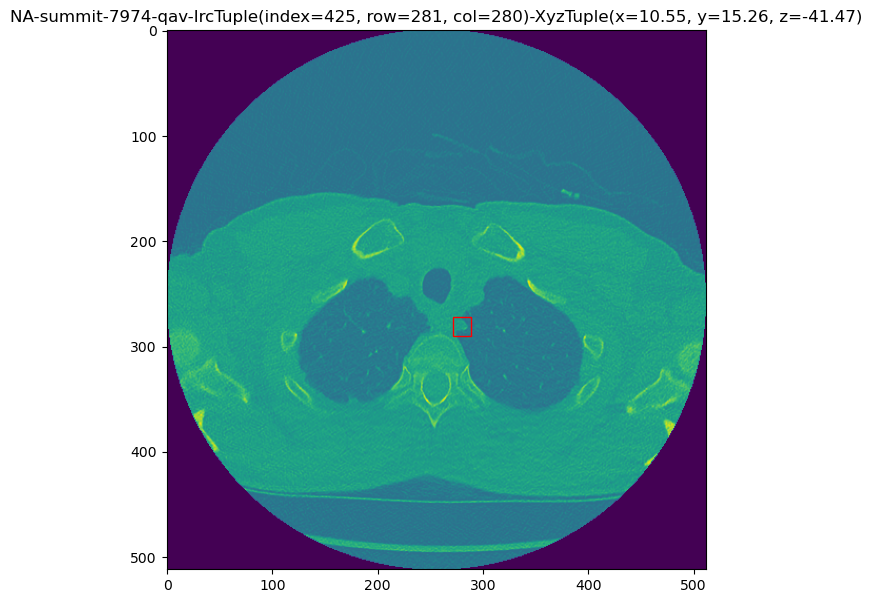

Copying clean and label from remote to local
Copying clean jmccabe@localhost:/cluster/project2/SUMMIT/cache/grt123/summit-7974-qav_Y0_BASELINE_A_* ../models/grt123/prep_result/.


scp: /cluster/project2/SUMMIT/cache/grt123/summit-7974-qav_Y0_BASELINE_A_*: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '../models/grt123/prep_result/summit-7974-qav_Y0_BASELINE_A_clean.npy'

In [37]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from pathlib import Path
import subprocess
import SimpleITK as sitk
from typing import List


DisplayTuple = namedtuple('DisplayTuple',['nodule_type','scan_id', 'image', 'xyz_coords', 'irc_coords', 'diameter'])

IrcTuple = namedtuple('IrcTuple',['index','row','col'])

XyzTuple = namedtuple('XyzTuple',['x','y','z'])

class SummitScan:
    """
    Author: John McCabe
    Description:  

    Attributes:
        pixel_array
        voxel_size
        origin
        orientation
    """
    def __init__(self, scan_uid, metadata, image) -> None:
        super().__init__()
        self.scan_uid = scan_uid
        self.metadata = metadata
        self.image = image

        # Pull out the salient bits of info needed
        self.origin = self.metadata.GetOrigin()
        self.voxel_size = self.metadata.GetSpacing()
        self.orientation = np.array(self.metadata.GetDirection()).reshape(3,3)

    @classmethod
    def load_scan(cls, path, type='MetaImageIO'):
        """
        Loads the scan from raw. Keeps all properties as part of the slices. 
        """

        # unique identifier can be found from file name
        scan_uid = Path(path).name.split('.')[0]

        # read in the scan
        if type == 'MetaImageIO':
            metadata = sitk.ReadImage(path)
            image = np.array(sitk.GetArrayFromImage(metadata), dtype=np.float32)

        return cls(scan_uid, metadata, image)

def xyz2irc(coord_xyz, origin, voxel_size, orientation=np.array([[1,0,0],[0,1,0],[0,0,1]])):

    origin_a = np.array(origin)
    voxel_size_a = np.array(voxel_size)
    coord_a = np.array(coord_xyz)

    cri_a = ((coord_a - origin_a) @ np.linalg.inv(orientation)) / voxel_size_a
    
    # it can only be whole numbers as irc
    cri_a = np.round(cri_a)
    return IrcTuple(index=int(cri_a[2]), row=int(cri_a[1]), col=int(cri_a[0]))

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def display_images(nodule_type_images):

    for idx, display_tuple in enumerate(nodule_type_images):
        image = display_tuple.image
        xyz = display_tuple.xyz_coords
        irc = display_tuple.irc_coords
        diameter = display_tuple.diameter

        fig, ax = plt.subplots(nrows=1,ncols=1)
        fig.set_size_inches(7,7)

        ax.imshow(image[irc.index,:,:])
        rect = patches.Rectangle((int(irc.col-((diameter+3)//2)), int(irc.row-((diameter+3)//2))),
                                 width=diameter+3,
                                 height=diameter+3,
                                 linewidth=1,
                                 edgecolor='r',
                                 facecolor='none')
        
        ax.add_patch(rect)
        ax.set_title(display_tuple.nodule_type + '-' + display_tuple.scan_id + '-' + str(irc) + '-' + str(xyz))
        plt.show()

def copy_scan_from_remote_to_local(study_id):
    # Define the source and destination paths
    source_path = f"jmccabe@localhost:/cluster/project2/SummitLung50/{study_id}/{study_id}_Y0_BASELINE_A.*"
    destination_path = f"../scans/SummitLung50/{study_id}/."

    Path(destination_path).mkdir(parents=True, exist_ok=True)

    # Execute the SCP command
    if not Path(destination_path, f"{study_id}_Y0_BASELINE_A.mhd").exists():
        subprocess.run(["scp", "-P", "2222", source_path, destination_path])
    else:
        print("File already exists locally")

def copy_clean_and_label_from_remote_to_local(study_id):
    # Define the source and destination paths
    source_path = f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/grt123/prep_result/{study_id}_Y0_BASELINE_A_*"
    destination_path = f"../models/grt123/prep_result/."

    # Execute the SCP command
    if not Path(destination_path, f"{study_id}_Y0_BASELINE_A_clean.npy").exists():
        print("Copying clean", source_path, destination_path)
        subprocess.run(["scp", "-P", "2222", source_path, destination_path])

def display_original_nodules(scan_path, metadata_path, study_id):
    
    scan = SummitScan.load_scan(scan_path)

    nodules = pd.read_csv(metadata_path)
    nodules = nodules[nodules.participant_id==study_id]

    print(nodules.shape)

    nodule_type_images = []
    for idx, row in nodules.iterrows():

        nodule_xyz = XyzTuple(x=row['nodule_x_coordinate'],
                                y=row['nodule_y_coordinate'],
                                z=row['nodule_z_coordinate'])
        
        nodule_irc = xyz2irc(coord_xyz=nodule_xyz,
                                origin=scan.origin,
                                voxel_size=scan.voxel_size,
                                orientation=scan.orientation)

        
        nodule_diameter = row['nodule_diameter_mm'] if row['nodule_diameter_mm'] else row['nodule_subsolid_major_axis_diameter']
        
        nodule_type_images.append(DisplayTuple(nodule_type='NA',
                                    scan_id=study_id,
                                    image=scan.image,
                                    xyz_coords=nodule_xyz,
                                    irc_coords=nodule_irc,
                                    diameter=int(nodule_diameter //scan.voxel_size[1]) ))

    display_images(nodule_type_images)

def display_processed_nodules(scan_path):

    clean = np.load(scan_path)
    nodules = np.load(scan.path.replace('clean', 'label'))

    nodule_type_images = []
    for nodule in nodules:

        xyz = XyzTuple(x=0, y=0, z=0)
        irc = IrcTuple(index=int(nodule[0]), col=int(nodule[2]), row=int(nodule[1]))
        d = nodule[3]

        nodule_type_images.append(DisplayTuple(nodule_type='na',
                                               scan_id='stem',
                                               image=clean[0,...],
                                               xyz_coords=xyz,
                                               irc_coords=irc,
                                               diameter=d))

    display_images(nodule_type_images)

def get_random_scan_id(name, dataset):
    """
    Returns a random scan id from the specified scan type. 
    """
    # Get the list of all scan ids
    scan_ids = pd.read_csv(f'../output/metadata/{name}/{dataset}_metadata.csv')['participant_id'].unique()

    # Return a random scan id
    return scan_ids[np.random.randint(len(scan_ids))]

def main():

    scan_id = get_random_scan_id('reduced', 'training')
    print(scan_id)

    original_image_path = f'../scans/SummitLung50/{scan_id}/{scan_id}_Y0_BASELINE_A.mhd'

    if not Path(original_image_path).exists():
        print("Copying scan from remote to local")
        copy_scan_from_remote_to_local(scan_id)
    else:
        print("Scan already exists locally")

    display_original_nodules(original_image_path, f'../output/metadata/reduced/training_metadata.csv', scan_id)


    processed_image_path = f'../models/grt123/prep_result/{scan_id}_Y0_BASELINE_A_clean.npy'

    if not Path(processed_image_path).exists():
        print("Copying clean and label from remote to local")
        copy_clean_and_label_from_remote_to_local(scan_id)
    else:
        print("Clean and label already exists locally")

    display_processed_nodules(processed_image_path)

main()
